# Практика №3

Теперь в качестве акустической модели мы будем использовать простой DNN классификатор. На каждом кадре записи мы будем подавать его вектор признаков на DNN, которая будет выдавать "распределение вероятностей" по фонемам. Далее это распределение мы будем использовать в нашем алгоритме распознавания по словарю. Схема работы такого классификатора представлена ниже: 

![](https://drive.google.com/uc?export=view&id=1dv0VuE8DIoKXETbvnZq2PMixkWMCJOxr)

### Bootstrap

In [1]:
!pip install --upgrade --no-cache-dir gdown

!gdown --id '1meikF0XqBUnVZKoY3160MQ0R25lq-EMu'
!gdown --id '1f0LkW6I3Q5CnOThuNFAJ9umgnb2eU4Ox'

!unzip -q lab2.zip
!unzip -q train_librispeech_10h.zip
!mv lab2 lab3
!mv train_librispeech_10h lab3/data
!rm -rf lab2.zip sample_data train_librispeech_10h.zip
%cd lab3

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1meikF0XqBUnVZKoY3160MQ0R25lq-EMu
To: /content/lab2.zip
100% 1.66M/1.66M [00:00<00:00, 78.4MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1f0LkW6I3Q5CnOThuNFAJ9umgnb2eU4Ox
To: /content/train_librispeech_10h.zip
100% 679M/679M [00:05<00:00, 127MB/s]
replace lab2/data/ali.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
replace train_librispeech_10h/ali_phones.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
mv: cannot move 'lab2' to 'lab3/lab2': Directory not empty
mv: cannot move 'train_libr

In [2]:
import os
import numpy as np
import time
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa, librosa.display
import torch
import torch.nn as nn
import torch.functional as F
import torch.optim.lr_scheduler as lr_scheduler


%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 5.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [3]:
torch.manual_seed(0)
np.random.seed(0)

In [5]:
# загрузка списка допустимых фонем:
def load_phones_dict(phones_file):
    phones_dict = {}
    with open(phones_file, encoding='utf-8') as fn:
        for index, line in enumerate(fn):
            phones_dict[line.strip()] = index
    return phones_dict

# загрузка покадровой фонемной разметки в словарь:
def load_phone_aligment(aligment_file):
    ali_dict = {}
    with open(aligment_file, encoding='utf-8') as fn:
        for line in fn:
            line = line.strip().split()
            ali_dict[line[0]] = line[1:]
    return ali_dict

# подсчет акустиеских признаков для записей из папки:
def load_data_dict(dir_path, count=None):
    data_dict = {}
    step = 0
    for wav_name in tqdm(os.listdir(dir_path)):
        x, sr = librosa.load(os.path.join(dir_path, wav_name), sr=None) 
        mfcc = librosa.feature.mfcc(x,
                                    sr=sr,
                                    n_mfcc=15, 
                                    n_fft=int(sr * 0.025),
                                    hop_length=int(sr * 0.01))
        step += 1
        if count and step == count:
            print(f'Early stop at {step}th file..')
            break
        data_dict[wav_name.split('.')[0]] = mfcc.T  
    return data_dict


phones_file = 'data/train_librispeech_10h/phones'
phones_dict = load_phones_dict(phones_file)

ali_file = 'data/train_librispeech_10h/ali_phones.txt'
ali_dict = load_phone_aligment(ali_file)

train_records_dir = 'data/train_librispeech_10h/wav_dir'
feats_dict = load_data_dict(train_records_dir, count=1000)

  0%|          | 0/3000 [00:00<?, ?it/s]

Early stop at 1000th file..


### Априорная вероятность:

![](https://drive.google.com/uc?export=view&id=1WhjclhXm2POYsCgvxp3iAIOvT9F_k8If)

http://data-science.wiki/images/Automatic_Speech_Recognition_RxtNVMXYTy.pdf

In [6]:
# объединение кадров признаков с соответствующими им фонемам:
def combain_data(ali_dict, feats_dict, phones_dict, side_context=None, stride=1):
    data_list = []
    priors_list = [0] * len(phones_dict)
    for file_name in feats_dict.keys():
        file_feats = feats_dict[file_name]
        file_ali = ali_dict[file_name]

        size = min(len(file_feats), len(file_ali))

        for frame in range(size):
            if side_context is None:
                data_list.append(
                    np.append(file_feats[frame], phones_dict[file_ali[frame]])
                )
            else:
                for delta in range(-side_context * stride, side_context * stride + 1, stride):
                    if frame + delta < 0:
                        frame_side = 0
                    elif frame + delta >= size:
                        frame_side = size - 1
                    else:
                        frame_side = frame + delta
                    if delta == -side_context * stride:
                        feats_side = file_feats[frame_side]
                    else:
                        feats_side = np.hstack((feats_side, file_feats[frame_side]))

                data_list.append(
                    np.append(feats_side, phones_dict[file_ali[frame]])
                )

            priors_list[phones_dict[file_ali[frame]]] += 1

    return data_list, np.array(priors_list)/sum(priors_list)

side_context = 5
stride = 1
data_list, priors_list = combain_data(ali_dict, feats_dict, phones_dict, side_context, stride)
data_list = np.random.permutation(data_list)

In [7]:
class CommonDataSet():

    def __init__(self, data_list, device, valid_proportion=0.1):
        self.train = data_list[:int((1-valid_proportion)*len(data_list))]
        self.valid = data_list[int((1-valid_proportion)*len(data_list)):]
        self.device = device
        
    def num_batches(self, batch_size):
        return len(self.train)//batch_size        
        
    def next_batch(self, batch_size):
        for i in range(self.num_batches(batch_size)):
            batch_xs = torch.tensor(self.train[i * batch_size:(i + 1) * batch_size, :-1], dtype=torch.float32)
            batch_ys = torch.tensor(self.train[i * batch_size:(i + 1) * batch_size,-1].ravel(), dtype=torch.int64)

            yield batch_xs.to(device), batch_ys.to(device)

In [8]:
class MyNNet(torch.nn.Module):

    def __init__(self, input_dim, output_dim):
        super(MyNNet, self).__init__()
        # params:
        ff_dim = 512

        self.ff_net = torch.nn.Sequential(
            
            nn.Linear(input_dim, ff_dim),
            nn.BatchNorm1d(ff_dim),
            nn.ReLU(),

            nn.Linear(ff_dim, ff_dim),
            nn.BatchNorm1d(ff_dim),
            nn.ReLU(),

            nn.Linear(ff_dim, ff_dim),
            nn.BatchNorm1d(ff_dim),
            nn.ReLU(),

            nn.Linear(ff_dim, ff_dim),
            nn.BatchNorm1d(ff_dim),
            nn.ReLU(),

            nn.Linear(ff_dim, output_dim)
        )


    def forward(self, x):
        x = self.ff_net(x)
        return (x)

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load data:
data_set = CommonDataSet(data_list, device)

batch_size = 256

# training network model:
start = time.time() 
nnet = MyNNet(
    input_dim=(data_list[0].shape[0] - 1),
    output_dim=len(phones_dict.keys())
).to(device)
weight = torch.ones(len(phones_dict))
weight[0] = 0.5
criterion = nn.CrossEntropyLoss(weight=weight.to(device))
optimizer = torch.optim.Adam(nnet.parameters(), lr=1e-3)
scheduler = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

loss_list = []

print('TRAINIG STARTED...')
for epoch in range(12):

    if epoch == 10:
        optimizer = torch.optim.SGD(nnet.parameters(), lr=1e-4, momentum=0.9)

    running_loss = 0
    counter = 0
    for batch_xs, batch_ys in tqdm(data_set.next_batch(batch_size), \
                                   total=data_set.num_batches(batch_size), \
                                   desc='epoch {}'.format(epoch)):
        optimizer.zero_grad()
        output = nnet(batch_xs)

        loss = criterion(output, batch_ys)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        counter += 1

    scheduler.step()
        
    print('loss is: {:.4f}'.format((running_loss / counter)))
    loss_list.append(running_loss / counter)
    
end = time.time()
minutes = (end - start) // 60
seconds = np.mod((end - start), 60)
print('Time is: {} min {} sec'.format(int(minutes), int(seconds)))

TRAINIG STARTED...


epoch 0:   0%|          | 0/4483 [00:00<?, ?it/s]

loss is: 1.4911


epoch 1:   0%|          | 0/4483 [00:00<?, ?it/s]

loss is: 1.2302


epoch 2:   0%|          | 0/4483 [00:00<?, ?it/s]

loss is: 1.0352


epoch 3:   0%|          | 0/4483 [00:00<?, ?it/s]

loss is: 0.9408


epoch 4:   0%|          | 0/4483 [00:00<?, ?it/s]

loss is: 0.8127


epoch 5:   0%|          | 0/4483 [00:00<?, ?it/s]

loss is: 0.7523


epoch 6:   0%|          | 0/4483 [00:00<?, ?it/s]

loss is: 0.6753


epoch 7:   0%|          | 0/4483 [00:00<?, ?it/s]

loss is: 0.6404


epoch 8:   0%|          | 0/4483 [00:00<?, ?it/s]

loss is: 0.5979


epoch 9:   0%|          | 0/4483 [00:00<?, ?it/s]

loss is: 0.5785


epoch 10:   0%|          | 0/4483 [00:00<?, ?it/s]

loss is: 0.5550


epoch 11:   0%|          | 0/4483 [00:00<?, ?it/s]

loss is: 0.5501
Time is: 3 min 25 sec


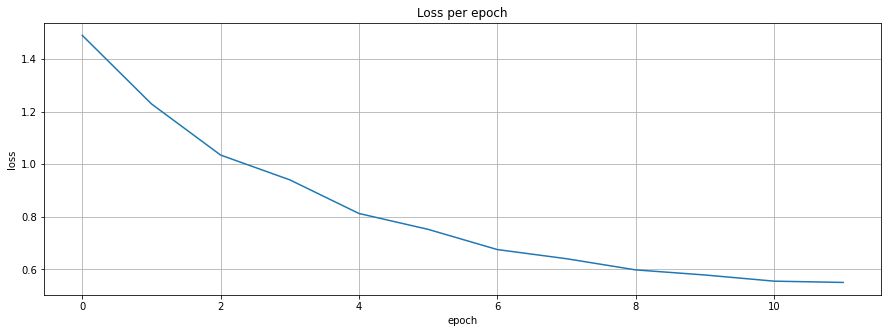

In [10]:
plt.rcParams['figure.figsize'] = (15.0, 5.0)
plt.plot(loss_list)
plt.title('Loss per epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()
plt.show()

In [11]:
class_correct = [0 for x in range(len(phones_dict.keys()))]
class_total = [0 for x in range(len(phones_dict.keys()))]

nnet.cpu()

nnet.eval()
with torch.no_grad():
    correct_cnt = 0
    for ftr, true_label in tqdm(zip(data_set.valid[:, :-1], data_set.valid[:, -1]), total=data_set.valid.shape[0]):
        ftr = torch.from_numpy(ftr).float()[None, ...]
        output = nnet.forward(ftr)
        predicted_label = output.argmax().item()
        correct_cnt += (predicted_label == true_label)
        class_correct[predicted_label] += (predicted_label == int(true_label))
        class_total[int(true_label)] += 1
        
print("Total frame accuracy is {:.3f}\n".format(correct_cnt / data_set.valid.shape[0]))

for idx, phone in enumerate(phones_dict.keys()):
    if class_total[idx]:
        print('{:3s}: {:.2f} : {}/{}'.format(phone, class_correct[idx] / class_total[idx], \
                                                     class_correct[idx], class_total[idx]))

  0%|          | 0/127534 [00:00<?, ?it/s]

Total frame accuracy is 0.737

SIL: 0.96 : 21923/22952
SPN: 0.29 : 222/774
AA0: 0.05 : 2/41
AA1: 0.66 : 1214/1830
AA2: 0.21 : 18/86
AE0: 0.11 : 6/53
AE1: 0.73 : 2560/3514
AE2: 0.30 : 31/102
AH0: 0.61 : 3430/5638
AH1: 0.58 : 1022/1769
AH2: 0.15 : 5/34
AO0: 0.37 : 13/35
AO1: 0.75 : 1526/2030
AO2: 0.28 : 15/54
AW0: 0.70 : 7/10
AW1: 0.69 : 781/1125
AW2: 0.31 : 15/48
AY0: 0.16 : 7/45
AY1: 0.82 : 2464/3006
AY2: 0.28 : 52/185
B  : 0.64 : 1001/1555
CH : 0.60 : 501/838
D  : 0.54 : 2122/3915
DH : 0.70 : 1391/1991
EH0: 0.22 : 12/55
EH1: 0.58 : 1675/2865
EH2: 0.12 : 11/94
ER0: 0.64 : 1648/2594
ER1: 0.63 : 585/925
ER2: 0.16 : 3/19
EY0: 0.26 : 7/27
EY1: 0.78 : 1853/2388
EY2: 0.31 : 38/124
F  : 0.80 : 1874/2355
G  : 0.55 : 451/816
HH : 0.68 : 1452/2130
IH0: 0.43 : 1152/2684
IH1: 0.54 : 1251/2314
IH2: 0.13 : 12/94
IY0: 0.67 : 1476/2201
IY1: 0.71 : 1637/2300
IY2: 0.24 : 15/63
JH : 0.61 : 390/637
K  : 0.76 : 2313/3031
L  : 0.79 : 3368/4252
M  : 0.75 : 2293/3047
N  : 0.78 : 4527/5832
NG : 0.65 : 847/1301

### Распознавание по словарю с помощью нейронной сети

In [70]:
# теперь будем распознавать по словарю, состоящему из конечных слов
# для этого нужно загрузить файл лексикона, который определяет из каких фонем состоят наши слова
def load_lexicon_dict(lexicon_file):
    lexicon_dict = {}
    with open(lexicon_file, encoding='utf-8') as fn:
        for line in fn:
            line = line.strip().split()
            lexicon_dict[line[0]] = line[1:]
    return lexicon_dict

In [71]:
class AcousticModel:
    def __init__(self, phone_name, phone_index, priors_list):
        self.phone_name = phone_name
        self.phone_index = phone_index
        self.phone_prior = priors_list[phone_index]
        
    def distance(self, input_feats, nnet):
        with torch.no_grad():
            predicts = nnet.forward(torch.tensor(input_feats, dtype=torch.float32))
            softmax = torch.nn.functional.softmax(predicts, dim=0)
        return -np.log(softmax[self.phone_index].item() / self.phone_prior)

class State:
    def __init__(self, model, index):  
        self.model = model                     # вектор признаков узла
        self.is_final = False                  # является ли этот узел финальнвм в слове
        self.word = None                       # слово эталона (назначается только для финального узла)
        self.best_token = None                 # лучший токен (по минимуму дистанции) в узле
        self.current_word = None               # текущее слово эталона
        self.next_states = []                  # список следующих узлов
        self.index = index                     # индекс узла 

        
def load_graph(lexicon_dict, phones_dict, priors_list):
    start_state = State(None, 0)
    graph = [start_state, ]
    state_index = 1
    for word in lexicon_dict.keys():
        previous_state = start_state
        for phone in lexicon_dict[word]:
            state = State(AcousticModel(phone, phones_dict[phone], priors_list), state_index)
            state.current_word = word           # слово эталона теперь будет храниться в каждом узле
            state.next_states.append(state)     # add loop
            previous_state.next_states.append(state)
            previous_state = state 
            graph.append(state)
            state_index += 1
        if state:
            state.word = word
            state.is_final = True
    return graph

In [12]:
class Token:
    def __init__(self, state, dist=0.0, word=""):
        self.state = state       # стейт графа, в котором токен находится в текущий момент
        self.dist = dist         # общая накопленная дистанция пути, пройденного токеном
        self.word = word         # слово, которое распозналось токеном
        self.alive = True


def beam_pruning(next_tokens, threshold):   
    alive_tokens = [token for token in next_tokens if token.alive]
    best_token = alive_tokens[np.argmin([token.dist for token in alive_tokens if token.alive])]
    for token in next_tokens:
        if token.dist > best_token.dist + threshold:
            token.alive = False
    return next_tokens


def state_pruning(next_tokens):
    for i in range(len(next_tokens)): 
        state_index = next_tokens[i].state.index
        if not graph[state_index].best_token:
            graph[state_index].best_token = next_tokens[i]
        else:
            if next_tokens[i].dist <= graph[state_index].best_token.dist:
                graph[state_index].best_token.alive = False
                graph[state_index].best_token = next_tokens[i]
            else:
                next_tokens[i].alive = False
    for token in next_tokens:                           
        index = token.state.index                        
        if graph[index].best_token:                     
            graph[index].best_token = None              
    return next_tokens


def recognize(filename, features, graph, nnet, recognition_results, beam_threshold):

    start_state = graph[0]
    active_tokens = [Token(start_state), ]
    next_tokens = []
    
    for frame in range(len(features)):
        if side_context is None:
            ftr_frame = features[frame]
        else:
            for delta in range(-side_context * stride, side_context * stride + 1, stride):
                if frame + delta < 0:
                    frame_side = 0
                elif frame + delta >= len(features):
                    frame_side = len(features) - 1
                else:
                    frame_side = frame + delta
                if delta == -side_context * stride:
                    ftr_frame = features[frame_side]
                else:
                    ftr_frame = np.hstack((ftr_frame, features[frame_side]))

        for token in active_tokens:
            if token.alive:
                for transition_state in token.state.next_states:
                    new_token = Token(transition_state, token.dist, token.word)
                    new_token.dist += transition_state.model.distance(ftr_frame, nnet)
                    next_tokens.append(new_token)
        # state and beam prunings:
        next_tokens = state_pruning(next_tokens)         
        next_tokens = beam_pruning(next_tokens, beam_threshold) 

        active_tokens = next_tokens
        next_tokens = []                                    
        
    # поиск финальных токенов:
    final_tokens = []
    for token in active_tokens:
        if token.state.is_final and token.alive:
            final_tokens.append(token)

    # если нет финальных, то берем лучший из выживших:
    if len(final_tokens) != 0:
        win_token = final_tokens[np.argmin([token.dist for token in final_tokens])]
    else:
        alive_tokens = [token for token in active_tokens if token.alive]
        win_token = alive_tokens[np.argmin([token.dist for token in alive_tokens])]
        win_token.state.word = win_token.state.current_word

    # вывод результата
    print(f"result: {filename:<27} ==> {win_token.state.word}")

    # совпадает ли запись с полученным эталоном:  
    record_word = filename.split('_')[0]
    etalon_word = win_token.state.word.split('_')[0]
    recognition_results.append(etalon_word.lower() == record_word)

    return recognition_results

In [73]:
def run_recognizer(records_data_dict, graph, nnet, beam_threshold=10):
    start_time = time.time()
    recognition_results = []

    for filename in records_data_dict.keys():    
        recognition_results = recognize(filename,
                                        records_data_dict[filename],
                                        graph, nnet,
                                        recognition_results, beam_threshold)

    print("-" * 60)
    print(f"WER is: {(1 - sum(recognition_results)/len(recognition_results))*100:.2f}%")
    print(f"Total time is: {time.time() - start_time:.2f} sec")
    print("-" * 60)

### Запустим распознавание на базе YES_NO

In [74]:
lexicon_file = 'data/lexicon_yes_no.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, phones_dict, priors_list)
records_data_dict = load_data_dict("data/yes_no/records")

run_recognizer(records_data_dict, graph, nnet.cpu(), beam_threshold=10)

  0%|          | 0/10 [00:00<?, ?it/s]

result: yes_fc94edb0_nohash_0       ==> YES
result: yes_ff63ab0b_nohash_0       ==> YES
result: yes_fe1916ba_nohash_0       ==> YES
result: no_41474817_nohash_0        ==> NO
result: no_49af4432_nohash_0        ==> NO
result: no_ad89eb1e_nohash_0        ==> NO
result: yes_39a12648_nohash_0       ==> YES
result: no_4394fc7c_nohash_0        ==> NO
result: no_4abb2400_nohash_0        ==> NO
result: yes_39a6b995_nohash_0       ==> YES
------------------------------------------------------------
WER is: 0.00%
Total time is: 0.55 sec
------------------------------------------------------------


### Запустим распознавание на базе Digits

In [75]:
lexicon_file = 'data/lexicon_digits.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, phones_dict, priors_list)
records_data_dict = load_data_dict("data/digits/records")
run_recognizer(records_data_dict, graph, nnet.cpu(), beam_threshold=100)

  0%|          | 0/20 [00:00<?, ?it/s]

result: three_feb1d305_nohash_0     ==> THREE
result: nine_fbe51750_nohash_0      ==> NINE
result: zero_f92e49f3_nohash_3      ==> ZERO
result: one_ffa76c4a_nohash_0       ==> ONE
result: eight_daf230ac_nohash_0     ==> EIGHT
result: nine_ccea893d_nohash_0      ==> NINE
result: two_fce65496_nohash_0       ==> TWO
result: one_fc2411fe_nohash_0       ==> NINE
result: four_ffbb695d_nohash_0      ==> FOUR
result: zero_f852895b_nohash_0      ==> ZERO
result: five_ffd2ba2f_nohash_0      ==> FIVE
result: five_f852895b_nohash_0      ==> FIVE
result: two_fb2f3242_nohash_0       ==> TWO
result: six_ffd2ba2f_nohash_0       ==> SIX
result: seven_fd32732a_nohash_0     ==> SEVEN
result: seven_fe5c4a7a_nohash_0     ==> SEVEN
result: six_ffbb695d_nohash_0       ==> SIX
result: four_fce65496_nohash_0      ==> FOUR
result: eight_da584bc0_nohash_4     ==> EIGHT
result: three_fce96bac_nohash_0     ==> THREE
------------------------------------------------------------
WER is: 5.00%
Total time is: 10.09 sec

### <b>Задание №1</b> (5 баллов):
Реализовать контексты для входных признаков путем конкатенации кадров слева и справа от текущего. Не забудьте поддержать это и в функции распознавания. Насколько улучшилось качество на дата сетах?

![](https://drive.google.com/uc?export=view&id=1ft0z6CPhX20cJnA373uLoYwHPEagaKyo)

### **Ответ**:

Алгоритм учета контекста реализован в ячейках 6 и 12.

**side_context** отвечает за количество соседних фонем слева и справа, которые мы используем, **stride** - за шаг между фонемами. 

Например, если **side_context = 2** и **stride = 2**, то будут учтены 2-ые и 4-ые фонемы слева и справа. 

Для паддинга происходит дублирование признаков крайних фонем нужное число раз.

Для данного задания менялись только 2 параметра: **side_context** и **stride**. Все остальные параметры фиксировались. Полученные результаты приведены в таблице ниже:

||$\textbf{Train loss}$|$\textbf{Total frame accuracy}$|$\textbf{YES_NO} \\ \textbf{WER, %} $|$\textbf{DIGITS} \\ \textbf{WER %}$|
|-|-|-|-|-|
|$\textbf{side_context=None}$|**2.1030**|**0.414**|**10**|**20**|
|$\textbf{side_context=1} \\ \textbf{stride=1}$|**1.7664**|**0.493**|**0**|**5**|
|$\textbf{side_context=2} \\ \textbf{stride=1}$|**1.5778**|**0.533**|**10**|**20**|
|$\textbf{side_context=3} \\ \textbf{stride=1}$|**1.4357**|**0.569**|**10**|**0**|
|$\textbf{side_context=4} \\ \textbf{stride=1}$|**1.3371**|**0.591**|**0**|**5**|
|$\textbf{side_context=5} \\ \textbf{stride=1}$|**1.2663**|**0.607**|**0**|**5**|
|||||
|$\textbf{side_context=2} \\ \textbf{stride=2}$|**1.3775**|**0.582**|**10**|**5**|
|$\textbf{side_context=2} \\ \textbf{stride=3}$|**1.3353**|**0.594**|**0**|**5**|

**Выводы:**
* При увеличении **side_context** или **stride** точность распознавания фонем по всем фреймам (total frame accuracy) растет. Без использования **side_context** она была равны ~0.41, при **side_context = 5** точность распознавания фонем уже равна ~0.61
* Ошибка распознавания слов YES/NO особо не поменялась при изменении **side_context** или **stride**. Она скачет, то 10%, то 0%. Наверное, это еще связано с тем, что данная метрика считается на 10 записях. И плюс-минус одна запись (плюс-минус 10%) выглядит как некий шум. Не хватает записей для более стабильной статистики. Но может и не прав здесь.
* На цифрах ошибка без использования **side_context** составляла 20%. При использовании **side_context** она в среднем равна 5%. Есть некий "выброс" до 20% при **side_context = 2**.
* Увеличение **stride** также ведет к увеличению качества при одинаковом **side_context**. Например, при **side_context = 2** и **stride = 1** точность распознавания фонем равна ~0.53, а при **stride = 3** точность уже составляет ~0.59.

### <b>Задание №2</b> (5 баллов):
Повысить качество классификации фонем за счет улучшения архитектуры нейронной сети, оптимизатора, расписания скорости обучения, других речевых признаков и т.п. Составить небольшой отчет на основе результатов перебора использованных способов. 

### **Ответ**:

Подход в этом задании будет следующим:
* Сначала подберем архитектуру сети при **side_context = None**. Выберем архитектуру с лучшим показателем **Total Frame Accuracy**. 
* Для выбранной архитектуры обучим сеть на признаках с **side_context = 5**. И посмотрим на итоговый прирост качества.
* Далее увеличим число файлов для формирования признаков до 1500, а также количество **mfcc** признаков до 15. И посмотрим, добавляют ли качества данные изменения.

Рассмотренные архитектуры и полученные точности приведены в таблице ниже. В колонке архитектуры описаны только изменения по сравнению с исходной архитектурой.

|$\textbf{Архитектура сети}$|$\textbf{Total Frame Accuracy}$|
|-|-|
|**1.** Исходная архитектура|$\textbf{0.414}$|
|**2.** 3 слоя по 256 нейронов|$\textbf{0.425}$|
|**3.** 4 слоя по 256 нейронов|$\textbf{0.429}$|
|**4.** 2 слоя по 512 нейронов|$\textbf{0.419}$|
|**5.** 4 слоя по 512 нейронов|$\textbf{0.438}$|
|**6.** 4 слоя по 256 нейронов + батч.нормализация после каждого слоя|$\textbf{0.443}$|
|**7.** 4 слоя по 512 нейронов + батч.нормализация после каждого слоя|$\textbf{0.453}$|
|**8.** 4 слоя по 512 нейронов + батч.нормализация после каждого слоя +
${\ \ \ \ }$умножение **lr** каждые три эпохи на 0.1 (стартовый **lr** = 1e-3)|$\textbf{0.450}$|
|**9.** 4 слоя по 512 нейронов + батч.нормализация после каждого слоя +
${\ \ \ \ }$умножение **lr** каждые две эпохи на 0.5 (стартовый **lr** = 1e-3)|$\textbf{0.458}$|
|**10.** 4 слоя по 512 нейронов + батч.нормализация после каждого слоя +
${\ \ \ \ }$умножение **lr** каждые две эпохи на 0.5 (стартовый **lr** = 1e-3) +
${\ \ \ \ }$нормировочный коэффициент **0.5** для фонемы **SIL**|$\textbf{0.457}$|
|**11.** 4 слоя по 512 нейронов + батч.нормализация после каждого слоя +
${\ \ \ \ }$умножение **lr** каждые две эпохи на 0.5 (стартовый **lr** = 1e-3) +
${\ \ \ \ }$нормировочный коэффициент **0.5** для фонемы **SIL** +
${\ \ \ \ }$2 эпохи с использованием SGD(lr=1e-4, momentum=0.9)|$\textbf{0.459}$|

Остановимся на последней архитектуре (№11 в таблице). 

* При обучении сети с данной архитектурой на признаках фонем с учетом **side_context = 5** метрика **total frame accuracy = 0.731**, что на **0.12** лучше, чем при использовании нейронной сети с исходной архитектурой.

* При использовании **1500** файлов точность упала до **0.718**

* При испльзовании 15 **mfcc** признаков на 1000 файлах точность составила: **0.737**


> **ВЫВОД**
>
> Удалось достичь точности распознавания фонем **0.737** при использовании **side_context = 5**, 15 **mfcc** признаков и следующей архитектуры сверточной нейронной сети:
>
> * 4 скрытых слоя по 512 нейронов
> * батч. нормализация после каждого слоя
> * использование Adam на 10 эпохах + SGD на 2 эпохах
> * использование scheduler = StepLR(step_size=2, gamma=0.5)
> * нормировочный коэффициент 0.5 для фонемы SIL в CrossEntropyLoss



